# Challenge solution - Neural Events Sorting


## Background information

As many of you may already know, the biological neural networks consists of specialized cells - neurons. These cells communicate with each other through electrochemical signals: if the signal potential (strength) reaches a specific boundary, the signal activates the surrounding neuron which repeats the procedure.

The study of individual neuron signals is not as straightforward as it might seem: the inserted "sensor" (electrode) records activity of all densely packed neurons which makes it hard to differentiate individual signals.

This is where our task comes in - we will have to create a model that takes this dense data and uses clustering to differentiate individual signals.

## Tasks

- Use the neural activity data to build K-Means clustering model that clusters waveforms according to similarities.
- Prior to model building, you might need to use PCA for dimensional reduction as well as preprocessing methods.

## Coding
### Data preprocessing

As always, we will be starting with importing and preprocessing data. As you can notice the following section contains some functions that **should not be changed** (```read_ncs()``` and ```filter_data()```). The first function is responsible for reading .ncs format file, while the second function filters data for you.

Your job here is to:
- Define the file path
- Use functions to read the data (that is then filtered)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import sklearn

C:\Users\marty\anaconda3\envs\ai_learning\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\marty\anaconda3\envs\ai_learning\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
C:\Users\marty\anaconda3\envs\ai_learning\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
#Define your file path
PATH = r"C:/Users/marty/Desktop/UCLA_data/CSC4.ncs"

In [3]:
#########---------DO NOT CHANGE THIS FUNCTION---------##################
def read_ncs(path):
    
    header_size   = 16 * 1024
    file = open(PATH, 'rb')
    file.seek(header_size)

    # Read data according to Neuralynx information
    data_format = np.dtype([('TimeStamp', np.uint64),
                        ('ChannelNumber', np.uint32),
                        ('SampleFreq', np.uint32),
                        ('NumValidSamples', np.uint32),
                        ('Samples', np.int16, 512)])

    raw = np.fromfile(file, dtype=data_format)
    
    file.close()
    
    sf = raw['SampleFreq'][0]
    data = raw['Samples'].ravel()
    durations = data.shape[0]  / sf
    
    
    return data, sf

def filter_data(data, low, high, sf, order = 2):
    nyq = sf / 2
    
    low = low / nyq
    high = high / nyq
    
    b, a = butter(order, [low, high], btype = 'band')
    
    filtered_data = lfilter(b, a, data)
    
    return filtered_data

In [4]:
#Read data from path, sf corresponds to sample frequency
data, sf = read_ncs(PATH)
filtered_data = filter_data(data, low = 500, high = 9000, sf = sf)

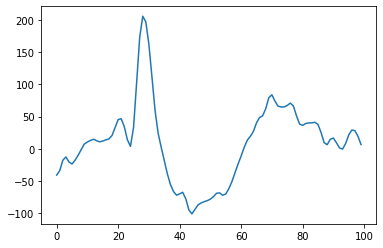

In [24]:
plt.plot(wave_form[spike, :])

#### Feature selection

At this point, we have imported our data and passed it through filter (*bandpass*). On the other hand, we have not yet selected features for our model. As we are to cluster the neural events according to similarity, it makes sense to extract spikes from the signal as they provide the most significance.

We have provided you a function for the spike extraction (```get_spikes()```). In short, the function takes specific window samples, goes through them and compares to a threshold. If the threshold is crossed, that window is considered to be a spike.

In [21]:
def get_spikes(data, spike_window=80, tf=5, offset=10, max_thresh=350):
    
    # Calculate threshold based on data mean
    thresh = np.mean(np.abs(data)) * tf

    # Find positions wherere the threshold is crossed
    pos = np.where(data > thresh)[0] 
    pos = pos[pos > spike_window]

    # Extract potential spikes and align them to the maximum
    spike_samp = []
    wave_form = np.empty([1, spike_window*2])
    for i in pos:
        if i < data.shape[0] - (spike_window+1):
            # Data from position where threshold is crossed to end of window
            tmp_waveform = data[i:i+spike_window*2]
            
            # Check if data in window is below upper threshold (artifact rejection)
            if np.max(tmp_waveform) < max_thresh:
                # Find sample with maximum data point in window
                tmp_samp = np.argmax(tmp_waveform) +i
                
                # Re-center window on maximum sample and shift it by offset
                tmp_waveform = data[tmp_samp-(spike_window-offset):tmp_samp+(spike_window+offset)]

                # Append data
                spike_samp = np.append(spike_samp, tmp_samp)
                wave_form = np.append(wave_form, tmp_waveform.reshape(1, spike_window*2), axis=0)
    
    # Remove duplicates
    ind = np.where(np.diff(spike_samp) > 1)[0]
    spike_samp = spike_samp[ind]
    wave_form = wave_form[ind]
    
    return spike_samp, wave_form

In [22]:
#Pass filtered data through function to extract the spike sample and wave form
spike_samp, wave_form = get_spikes(filtered_data, spike_window=50, tf=8, offset=20)

Let's visualize 100 random spikes just to understand why we are trying to apply clustering in the first place.

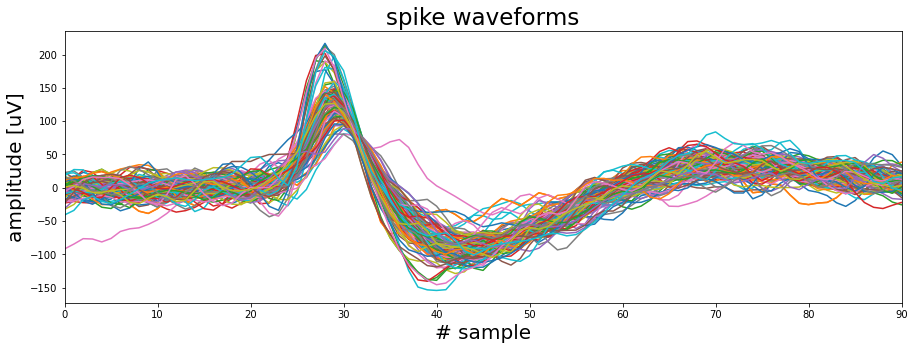

In [23]:
np.random.seed(10)
fig, ax = plt.subplots(figsize=(15, 5))

for i in range(100):
    spike = np.random.randint(0, wave_form.shape[0])
    ax.plot(wave_form[spike, :])

ax.set_xlim([0, 90])
ax.set_xlabel('# sample', fontsize=20)
ax.set_ylabel('amplitude [uV]', fontsize=20)
ax.set_title('spike waveforms', fontsize=23)
plt.show()

As you can see, the signals are quite near to each other, however, the analysis of such data would not be possible. That's why by clustering these signals, we can extract the most significant signals that can be used for later analysis.

### PCA

The features used for our model are spike signals that are quite complex. One of the possible solutions is to apply principle component analysis to extract only the most significant features.

In [10]:
# Pass wave_form through the prescaler
scaler= sklearn.preprocessing.MinMaxScaler()
dataset_scaled = scaler.fit_transform(wave_form)

# Pass scaled data through PCA
pca = PCA(n_components=12)
pca_result = pca.fit_transform(dataset_scaled)

Now let's visualize the principle components.

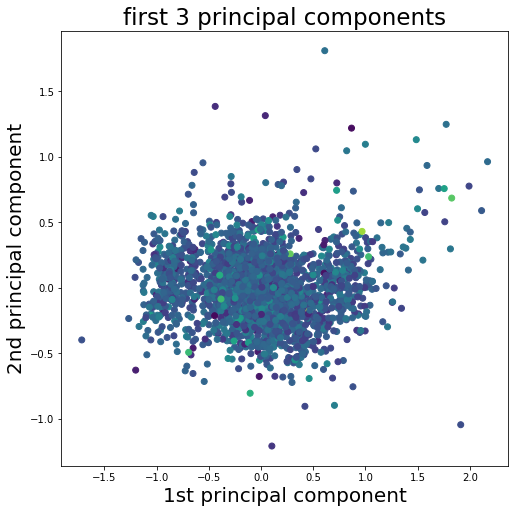

In [11]:
# Plot the 1st principal component aginst the 2nd and use the 3rd for color
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(pca_result[:, 0], pca_result[:, 1], c=pca_result[:, 2])
ax.set_xlabel('1st principal component', fontsize=20)
ax.set_ylabel('2nd principal component', fontsize=20)
ax.set_title('first 3 principal components', fontsize=23)

fig.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

### Building model

After extracting the principle components, we can apply K-Means clustering. Your task is to build and pass the model

In [12]:
#Build K-means model and pass primary components
model = KMeans(n_clusters=3, random_state=42)
model.fit(pca_result)

KMeans(n_clusters=3, random_state=42)

Visualize clusters

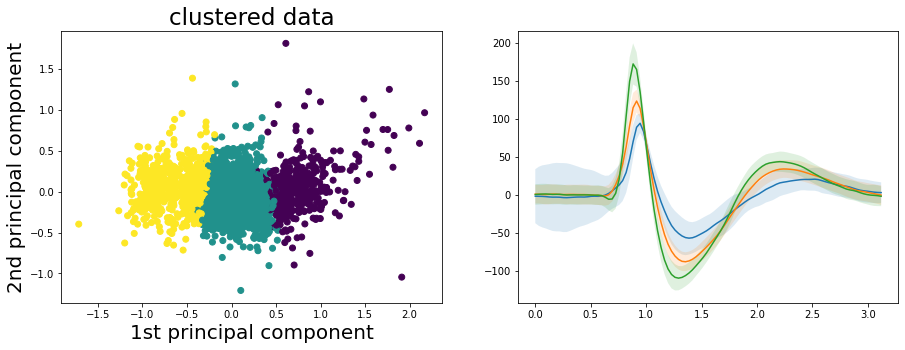

In [13]:
cluster = model.predict(pca_result)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].scatter(pca_result[:, 0], pca_result[:, 1], c=model.labels_)
ax[0].set_xlabel('1st principal component', fontsize=20)
ax[0].set_ylabel('2nd principal component', fontsize=20)
ax[0].set_title('clustered data', fontsize=23)

time = np.linspace(0, wave_form.shape[1]/sf, wave_form.shape[1])*1000

for i in range(3):
    cluster_mean = wave_form[cluster==i, :].mean(axis=0)
    cluster_std = wave_form[cluster==i, :].std(axis=0)
    
    ax[1].plot(time, cluster_mean, label='Cluster {}'.format(i))
    ax[1].fill_between(time, cluster_mean-cluster_std, cluster_mean+cluster_std, alpha=0.15)